In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from datetime import datetime as dt
from typing import \
    List, \
    Dict, \
    Callable
import math
from scipy.stats import norm


In [2]:
article_nbr = 1
symbol = 'CL'

final_df = pd.read_csv('../data/{}.csv'.format(symbol), 
                 index_col=0, 
                 header=0,
                 parse_dates=[0],
                 date_format='%Y-%m-%d')



# Non-Normalized Returns and Features

In [3]:
# our signals are based on the close
final_df['close_log_ret'] = np.log(final_df['CLOSE']) - np.log(final_df['CLOSE'].shift(1))

# EWMAC_32_128
final_df['close_ewma_32'] = final_df['CLOSE'].ewm(span=32, min_periods=32).mean()
final_df['close_ewma_128'] = final_df['CLOSE'].ewm(span=128, min_periods=128).mean()
# final_df['close_ewmac_32_128_pct'] = (final_df['close_ewma_32'] - final_df['close_ewma_128']) \
#         / ((final_df['close_ewma_32'].abs() + final_df['close_ewma_128'].abs()) / 2)
final_df['close_ewmac_32_128'] = (final_df['close_ewma_32'] - final_df['close_ewma_128'])


# forward return is open to open
final_df['open_log_ret'] = np.log(final_df['OPEN']) - np.log(final_df['OPEN'].shift(1))
final_df['1df_open_log_ret'] = final_df['open_log_ret'].shift(-2)



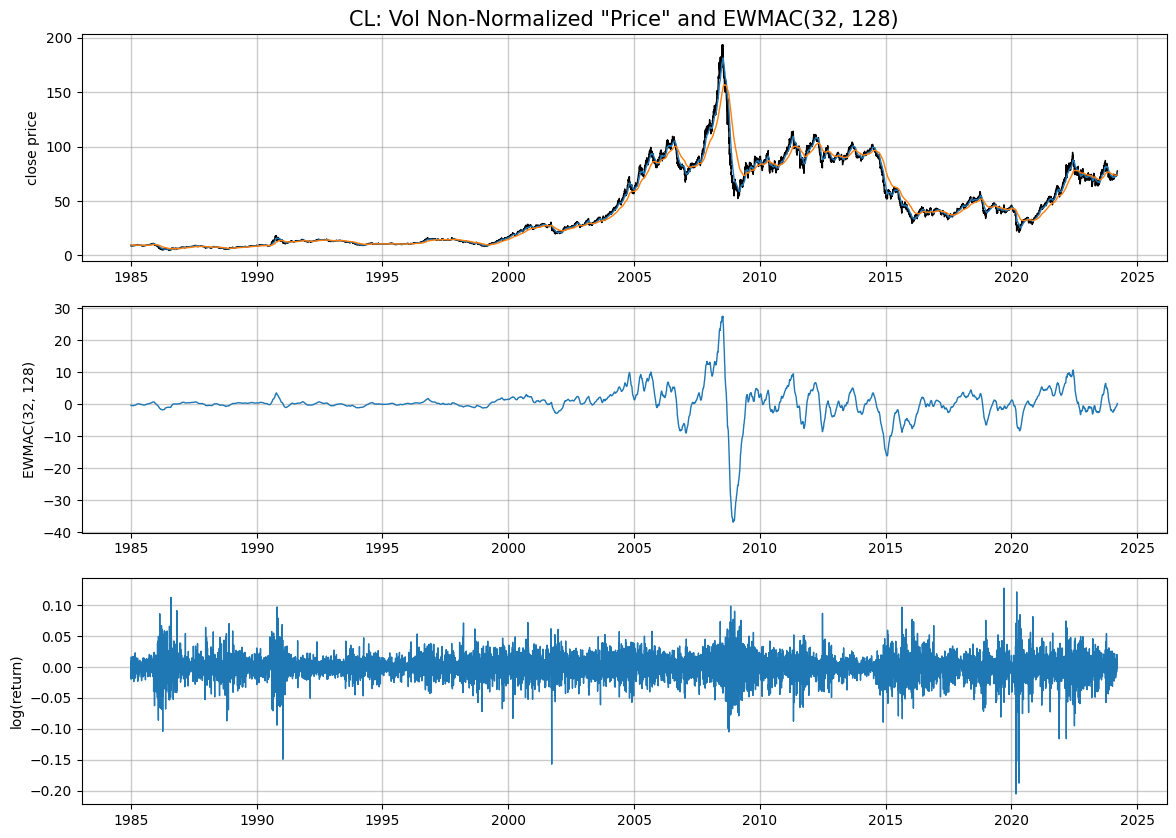

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 10))
ax1.set_title( '{}: Vol Non-Normalized "Price" and EWMAC(32, 128)'.format(symbol), fontsize=15)

ax1.plot(final_df['CLOSE']['1985':], color='black', linewidth='1')
ax1.set_ylabel('close price')
ax1.plot(final_df['close_ewma_32']['1985':], linewidth='1')
ax1.plot(final_df['close_ewma_128']['1985':], linewidth='1')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ln1 = ax2.plot(final_df['close_ewmac_32_128']['1985':], linewidth='1', label='close_ewmac_32_128')
ax2.set_ylabel('EWMAC(32, 128)')
ax2.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax3.plot(final_df['close_log_ret']['1985':], linewidth='1', label='close_log_ret')
ax3.set_ylabel('log(return)')
ax3.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

# lines = ln1 + ln2
# labels = [l.get_label() for l in lines]
# ax2.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_non_normalized_price_signal_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


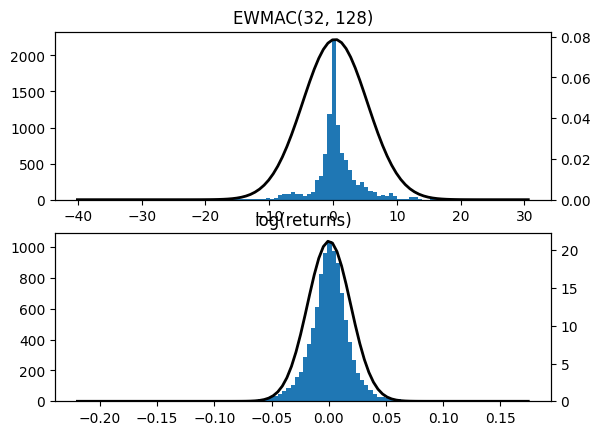

In [5]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(final_df['close_ewmac_32_128']['1985':], bins=100)
# ax1.set_xlim(-15, 15)
# plot normal distribution
ax11 = ax1.twinx()
mu = final_df['close_ewmac_32_128']['1985':].mean()
std = final_df['close_ewmac_32_128']['1985':].std()
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) 
ax11.plot(x, p, 'k', linewidth=2)
ax11.set_ylim(0, ax11.get_ylim()[1])
ax1.set_title('EWMAC(32, 128)')


ax2.set_title('log(returns)')
ax2.hist(final_df['1df_open_log_ret']['1985':], bins=100)
# plot normal distribution
ax21 = ax2.twinx()
mu = final_df['1df_open_log_ret']['1985':].mean()
std = final_df['1df_open_log_ret']['1985':].std()
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) 
ax21.plot(x, p, 'k', linewidth=2)
ax21.set_ylim(0, ax21.get_ylim()[1])


plt.savefig('../output/{}_{}_non_normalized_distribution_signal_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


In [6]:
x_axis_col_name = 'close_ewmac_32_128'
y_axis_col_name = '1df_open_log_ret'

# Buy & Hold model
bh_model_ann_vol = math.sqrt(252) * final_df[y_axis_col_name]['1985':].std()
bh_model_vol_mult = 0.2 / bh_model_ann_vol
final_df['bh_model_returns'] = bh_model_vol_mult * final_df[y_axis_col_name]
bh_model_sr = 252 * final_df['bh_model_returns']['1985':].mean() / 0.2


# linear model
final_df['linear_model_returns'] = final_df[y_axis_col_name] * final_df[x_axis_col_name]
lin_model_ann_vol = math.sqrt(252) * final_df['linear_model_returns']['1985':].std()
lin_model_vol_mult = 0.2 / lin_model_ann_vol
final_df['linear_model_returns'] = lin_model_vol_mult * final_df['linear_model_returns']
lin_model_sr = 252 * final_df['linear_model_returns']['1985':].mean() / 0.2

# classifier model
def binary_classifier(row):
    if row[x_axis_col_name] > 0:
        val = 1
    elif row[x_axis_col_name] < 0:
        val = -1
    else:
        val = 0
    return val
class_col_name = '{}_class'.format(x_axis_col_name)
final_df[class_col_name] = final_df.apply(binary_classifier, axis=1)
final_df['class_model_returns'] = final_df[y_axis_col_name] * final_df[class_col_name]
class_model_ann_vol = math.sqrt(252) * final_df['class_model_returns']['1985':].std()
class_model_vol_mult = 0.2 / class_model_ann_vol
final_df['class_model_returns'] = class_model_vol_mult * final_df['class_model_returns']
class_model_sr = 252 * final_df['class_model_returns']['1985':].mean() / 0.2

final_df['linear_model_pnl'] = final_df['linear_model_returns']['1985':].cumsum()
final_df['class_model_pnl'] = final_df['class_model_returns']['1985':].cumsum()
final_df['bh_pnl'] = final_df['bh_model_returns']['1985':].cumsum()


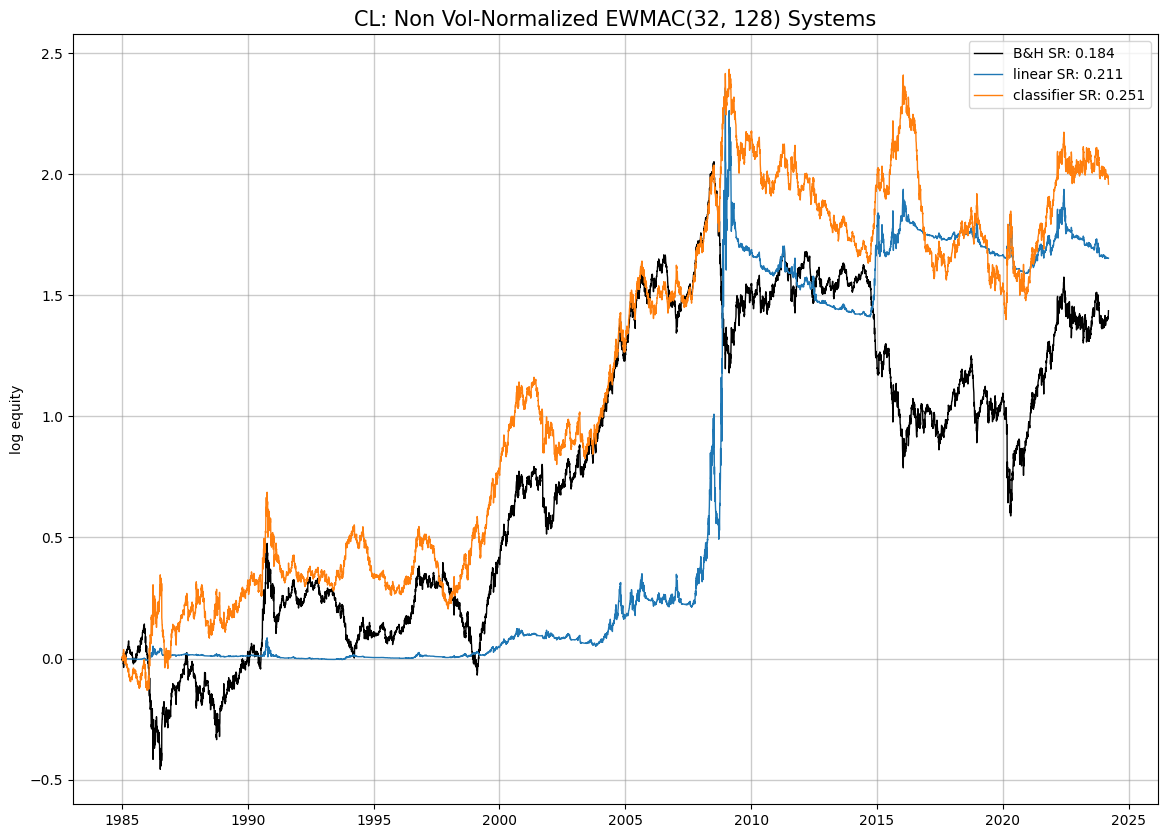

In [7]:

fig, ax1 = plt.subplots(figsize=(14, 10))
plt.title( '{}: Non Vol-Normalized EWMAC(32, 128) Systems'.format(symbol), fontsize=15)

ln1 = ax1.plot(final_df['bh_pnl'], color='black', linewidth='1', label='{} SR: {:4.3f}'.format('B&H', bh_model_sr))
# ax2 = ax1.twinx()
ln2 = ax1.plot(final_df['linear_model_pnl'], linewidth='1', label='{} SR: {:4.3f}'.format('linear', lin_model_sr))
ln3 = ax1.plot(final_df['class_model_pnl'], linewidth='1', label='{} SR: {:4.3f}'.format('classifier', class_model_sr))

plt.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)
plt.ylabel("log equity")

lines = ln1 + ln2 + ln3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_non_normalized_systems.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


# Vol Normalized Returns and Features

In [8]:
# our signals are based on the close
# calculate the vol, inclusing a short vol and a long vol floor
final_df['close_log_ret'] = np.log(final_df['CLOSE']) - np.log(final_df['CLOSE'].shift(1))
final_df['close_log_ret_sqr'] = final_df['close_log_ret'].pow(2)
final_df['close_log_ret_sqr_short'] = final_df['close_log_ret_sqr'].ewm(span=42, min_periods=42).mean()
final_df['close_vol_short'] = final_df['close_log_ret_sqr_short'].pow(0.5)
# final_df['close_log_ret_sqr_long'] = final_df['close_log_ret_sqr'].ewm(span=504, min_periods=42).mean()
# final_df['close_vol_long'] = final_df['close_log_ret_sqr_long'].pow(0.5)
# final_df['close_vol_long_floor'] = 0.5 * final_df['close_vol_long']
# final_df['close_vol'] = final_df[['close_vol_short', 'close_vol_long_floor']].max(axis=1)
final_df['close_vol'] = final_df['close_vol_short']
# final_df['close_ret_sr'] = final_df['close_log_ret'].std() * final_df['close_log_ret'] / final_df['close_vol']
final_df['close_ret_sr'] = final_df['close_log_ret'] / final_df['close_vol']
print('close_log_ret.std(): {}'.format(final_df['close_log_ret'].std()))
print('close_ret_sr.std(): {}'.format(final_df['close_ret_sr'].std()))


# EWMAC_32_128_NVOL
final_df['close_log_ret_sr_cumsum'] = final_df['close_ret_sr'].cumsum()
final_df['close_lsr_ewma_32'] = final_df['close_log_ret_sr_cumsum'].ewm(span=32, min_periods=32).mean()
final_df['close_lsr_ewma_128'] = final_df['close_log_ret_sr_cumsum'].ewm(span=128, min_periods=128).mean()
final_df['close_lsr_ewmac_32_128'] = (final_df['close_lsr_ewma_32'] - final_df['close_lsr_ewma_128'])


# forward return is open to open
final_df['open_log_ret'] = np.log(final_df['OPEN']) - np.log(final_df['OPEN'].shift(1))
final_df['1df_open_log_ret'] = final_df['open_log_ret'].shift(-2)
# final_df['1df_open_log_sr'] = (0.2 / math.sqrt(252)) * final_df['1df_open_log_ret'] / final_df['close_vol']
# # this is a bit weird, but I wanted it to be on a scale comparable to the log returns
final_df['1df_open_log_sr'] = final_df['close_log_ret'].std() * final_df['1df_open_log_ret'] / final_df['close_vol']
# final_df['1df_open_log_sr'] = final_df['1df_open_log_ret'] / final_df['close_vol']
print('1df_open_log_sr.std(): {}'.format(final_df['1df_open_log_sr'].std()))


close_log_ret.std(): 0.01842816902095515
close_ret_sr.std(): 0.9678459382537492
1df_open_log_sr.std(): 0.019814884684486573


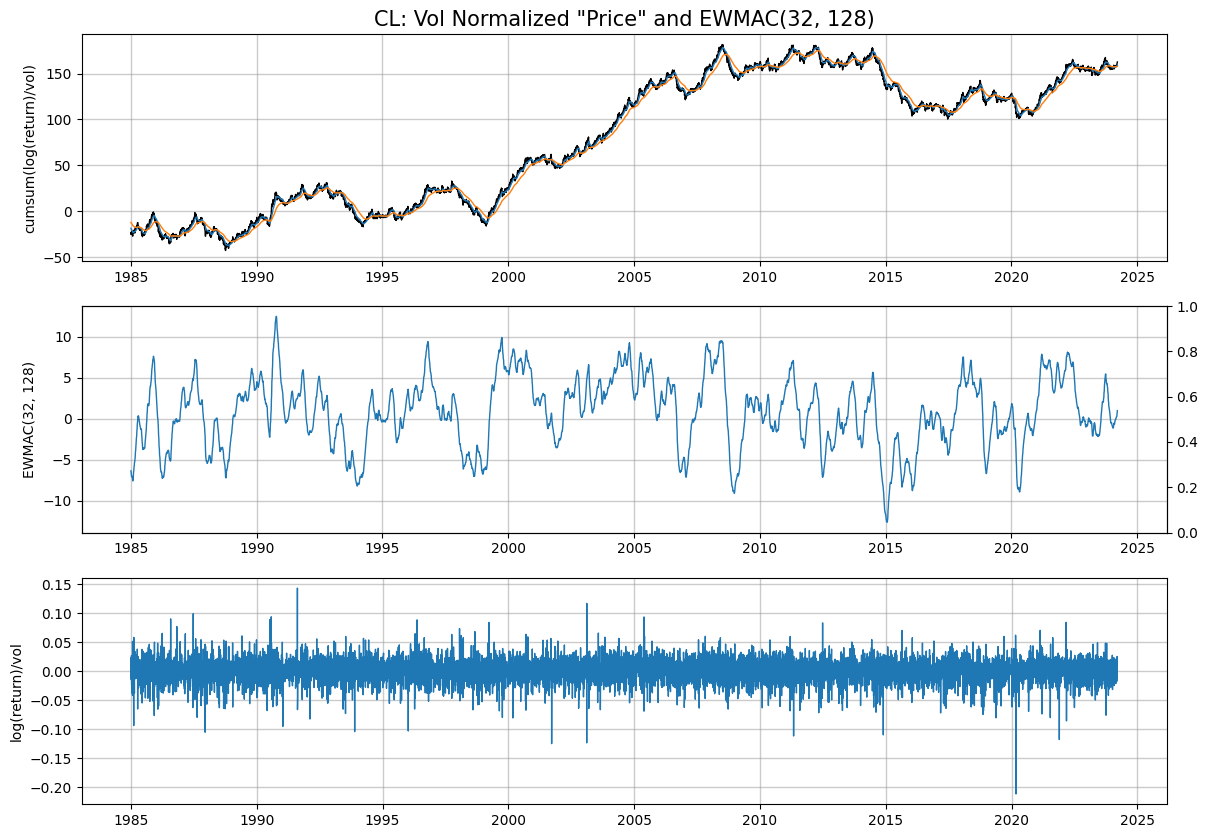

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 10))
ax1.set_title( '{}: Vol Normalized "Price" and EWMAC(32, 128)'.format(symbol), fontsize=15)

ax1.plot(final_df['close_log_ret_sr_cumsum']['1985':], color='black', linewidth='1')
ax1.set_ylabel('cumsum(log(return)/vol)')
ax1.plot(final_df['close_lsr_ewma_32']['1985':], linewidth='1')
ax1.plot(final_df['close_lsr_ewma_128']['1985':], linewidth='1')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax21 = ax2.twinx()
ln1 = ax2.plot(final_df['close_lsr_ewmac_32_128']['1985':], linewidth='1', label='close_lsr_ewmac_32_128')
# ax21.plot(final_df['close_vol']['1985':], color='red', linewidth='1')
# ln2 = ax21.plot(final_df['close_ewmac_32_128_nvol']['1985':], color='orange', linewidth='1', label='close_ewmac_32_128_nvol')
# ln2 = ax21.plot(final_df['close_lsr_ewmac_32_128_pct']['1985':], color='orange', linewidth='1', label='close_lsr_ewmac_32_128_pct')
# ax2.plot(final_df['close_ewma_32']['1985':], linewidth='1')
# ax2.plot(final_df['close_ewma_128']['1985':], linewidth='1')
ax2.set_ylabel('EWMAC(32, 128)')
ax2.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax3.plot(final_df['1df_open_log_sr']['1985':], linewidth='1', label='1df_open_log_sr')
ax3.set_ylabel('log(return)/vol')
ax3.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

# lines = ln1 + ln2
# labels = [l.get_label() for l in lines]
# ax2.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_normalized_price_signal_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


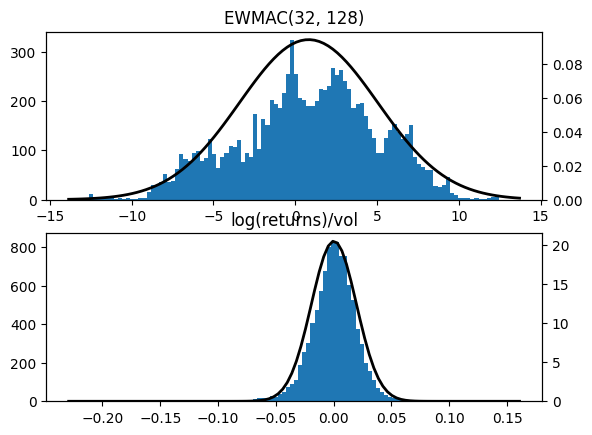

In [10]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(final_df['close_lsr_ewmac_32_128']['1985':], bins=100)
# ax1.set_xlim(-15, 15)
# plot normal distribution
ax11 = ax1.twinx()
mu = final_df['close_lsr_ewmac_32_128']['1985':].mean()
std = final_df['close_lsr_ewmac_32_128']['1985':].std()
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) 
ax11.plot(x, p, 'k', linewidth=2)
ax11.set_ylim(0, ax11.get_ylim()[1])
ax1.set_title('EWMAC(32, 128)')


ax2.set_title('log(returns)/vol')
ax2.hist(final_df['1df_open_log_sr']['1985':], bins=100)
# plot normal distribution
ax21 = ax2.twinx()
mu = final_df['1df_open_log_sr']['1985':].mean()
std = final_df['1df_open_log_sr']['1985':].std()
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) 
ax21.plot(x, p, 'k', linewidth=2)
ax21.set_ylim(0, ax21.get_ylim()[1])


# ax3.set_title('log(returns)/vol')
# ax3.hist(final_df['1df_open_log_sr']['1985':], bins=100)
# # plot normal distribution
# ax31 = ax3.twinx()
# mu = final_df['1df_open_log_sr']['1985':].mean()
# std = final_df['1df_open_log_sr']['1985':].std()
# xmin, xmax = ax3.get_xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std) 
# ax31.plot(x, p, 'k', linewidth=2)
# ax31.set_ylim(0, ax31.get_ylim()[1])


plt.savefig('../output/{}_{}_normalized_distribution_signal_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


In [11]:
x_axis_col_name = 'close_lsr_ewmac_32_128'
y_axis_col_name = '1df_open_log_sr'

# Buy & Hold model
bh_model_ann_vol = math.sqrt(252) * final_df[y_axis_col_name]['1985':].std()
bh_model_vol_mult = 0.2 / bh_model_ann_vol
final_df['bh_model_returns'] = bh_model_vol_mult * final_df[y_axis_col_name]
bh_model_sr = 252 * final_df['bh_model_returns']['1985':].mean() / 0.2


# linear model
final_df['linear_model_returns'] = final_df[y_axis_col_name] * final_df[x_axis_col_name]
lin_model_ann_vol = math.sqrt(252) * final_df['linear_model_returns']['1985':].std()
lin_model_vol_mult = 0.2 / lin_model_ann_vol
final_df['linear_model_returns'] = lin_model_vol_mult * final_df['linear_model_returns']
lin_model_sr = 252 * final_df['linear_model_returns']['1985':].mean() / 0.2

# classifier model
def binary_classifier(row):
    if row[x_axis_col_name] > 0:
        val = 1
    elif row[x_axis_col_name] < 0:
        val = -1
    else:
        val = 0
    return val
class_col_name = '{}_class'.format(x_axis_col_name)
final_df[class_col_name] = final_df.apply(binary_classifier, axis=1)
final_df['class_model_returns'] = final_df[y_axis_col_name] * final_df[class_col_name]
class_model_ann_vol = math.sqrt(252) * final_df['class_model_returns']['1985':].std()
class_model_vol_mult = 0.2 / class_model_ann_vol
final_df['class_model_returns'] = class_model_vol_mult * final_df['class_model_returns']
class_model_sr = 252 * final_df['class_model_returns']['1985':].mean() / 0.2


final_df['linear_model_pnl'] = final_df['linear_model_returns']['1985':].cumsum()
final_df['class_model_pnl'] = final_df['class_model_returns']['1985':].cumsum()
final_df['bh_pnl'] = final_df['bh_model_returns']['1985':].cumsum()


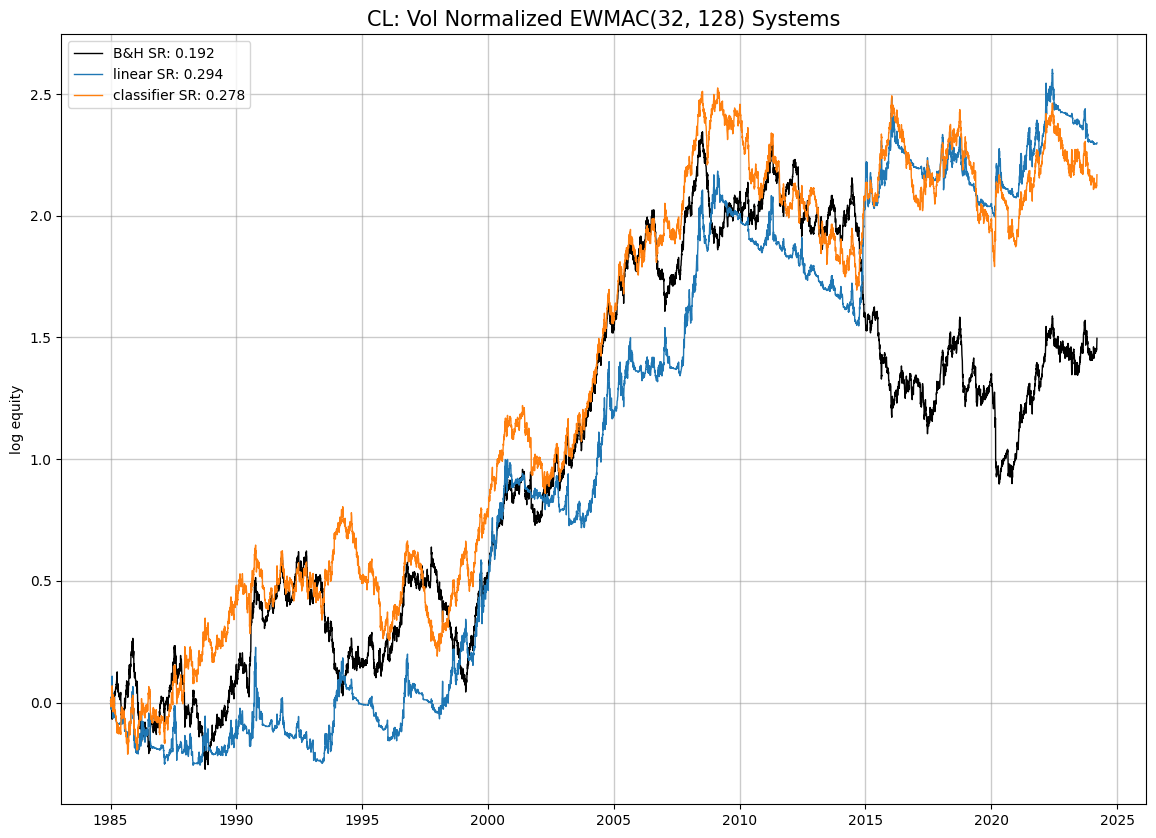

In [12]:

fig, ax1 = plt.subplots(figsize=(14, 10))
plt.title( '{}: Vol Normalized EWMAC(32, 128) Systems'.format(symbol), fontsize=15)

ln1 = ax1.plot(final_df['bh_pnl'], color='black', linewidth='1', label='{} SR: {:4.3f}'.format('B&H', bh_model_sr))
# ax2 = ax1.twinx()
ln2 = ax1.plot(final_df['linear_model_pnl'], linewidth='1', label='{} SR: {:4.3f}'.format('linear', lin_model_sr))
ln3 = ax1.plot(final_df['class_model_pnl'], linewidth='1', label='{} SR: {:4.3f}'.format('classifier', class_model_sr))

plt.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)
plt.ylabel("log equity")

lines = ln1 + ln2 + ln3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_normalized_systems.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)

